### **Sinusoidal Positional Encodings**

In Transformer models, **sinusoidal positional encodings** are used to inject position information into token or patch embeddings without using recurrence or convolution.

The encoding formula is:

$$
\begin{align*}
PE(pos, 2i) &= \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right) \\
PE(pos, 2i + 1) &= \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)
\end{align*}
$$

Where:
- `pos` is the position index (e.g., 0 to 10,000)
- `i` indexes half of the embedding dimension
- `d_model` is the total embedding dimension

#### **Why Positional Encoding is Necessary in Transformers**

Transformer architectures are **fully parallelized**, meaning they process all tokens (or image patches) **simultaneously** using matrix operations. This is a key advantage over recurrent models like RNNs or LSTMs, which must process tokens one at a time.

However, this parallelism **comes with a cost**: transformers have **no inherent sense of order**.

- In NLP, this means they don't know which word comes first, second, etc.
- In Vision Transformers (ViT), this means patches have no spatial sequence.

To solve this, we **inject position information** into the input embeddings. This allows the self-attention mechanism to attend not only to token content, but also to **where** each token appears in the input.

#### **Why Use Sinusoidal Positional Encoding?**

There are several methods to add positional information. The sinusoidal scheme is popular (especially in early transformer models) because:

- Continuous and Infinite: it can generate embeddings for **arbitrary positions** (even beyond those seen during training).

- Non-learnable but Effective: it doesn't require learning — yet it enables the model to generalize well across sequences.

- Encodes Relative Position: the difference between two encodings reflects their **relative distance**, which can be useful for reasoning over sequences.

- Smooth and Differentiable: smooth changes in input position lead to smooth changes in the encoding.

- Mathematically Sound: based on using **sine and cosine with exponentially scaled frequencies**, much like a Fourier basis.

- Lightweight: requires no extra parameters and is fast to compute.

#### **Could Two Different Positions Share the Same Encoding?**

Intuitively and practically, **the answer is no** — positional encodings are designed to be **unique per position** within a reasonable range.

Let’s understand why this is true both **intuitively** and **mathematically**.

<br>

**Intuition: Different Frequencies Prevent Overlap**

Each dimension uses a different frequency for its sine or cosine:

$$
\omega_i = \frac{1}{10000^{2i/d}}
$$

So the positional encoding vector for a given position is a **blend of many sinusoids** of different wavelengths.

Even though each individual sine or cosine is periodic, the **combination of many different, incommensurate frequencies** (i.e., their periods don’t align nicely) ensures that the overall vector pattern **doesn’t repeat**.

This is similar to how **Fourier features** encode signals in the frequency domain.

<br>

**Mathematical Perspective: No Shared Encoding Unless Identical Positions**

Suppose two different positions, `pos₁` and `pos₂`, produce the **same encoding**:

$$
PE(pos_1) = PE(pos_2)
$$

This implies that for every dimension `i`:

$$
\sin\left(\frac{pos_1}{10000^{2i/d}}\right) = \sin\left(\frac{pos_2}{10000^{2i/d}}\right)
$$

and similarly for cosine. This is only true if:

$$
\frac{pos_1 - pos_2}{10000^{2i/d}} = 2\pi n_i \quad \text{for some } n_i \in \mathbb{Z}
$$

In this equation:
- \( n_i \) is an integer representing how many full sinusoidal cycles exist between the two positions for the `i`-th frequency.
- For the equality to hold across **all dimensions**, the difference `pos₁ - pos₂` must be a common multiple of all the different sinusoidal periods — which grow exponentially.
- Hence, **it is extremely unlikely** unless `pos₁ = pos₂`.

Note that each period includes the factor \( \pi \), which is irrational, and the frequency terms \( 10000^{2i/d} \) vary across dimensions. As a result, the required difference \( pos_1 - pos_2 \) would need to be a common multiple of several irrational numbers — an impossibility unless \( pos_1 = pos_2 \). This further reinforces that exact collisions in encoding can’t occur.

<br>

**Numerical Uniqueness in Practice**

Even in float32 precision, positional encodings are **numerically distinct** for different positions when:
- `d_model ≥ 32`
- `pos ∈ [0, 10,000]`

The encoding vector is highly sensitive to changes in position, especially in low-indexed dimensions (which oscillate faster).

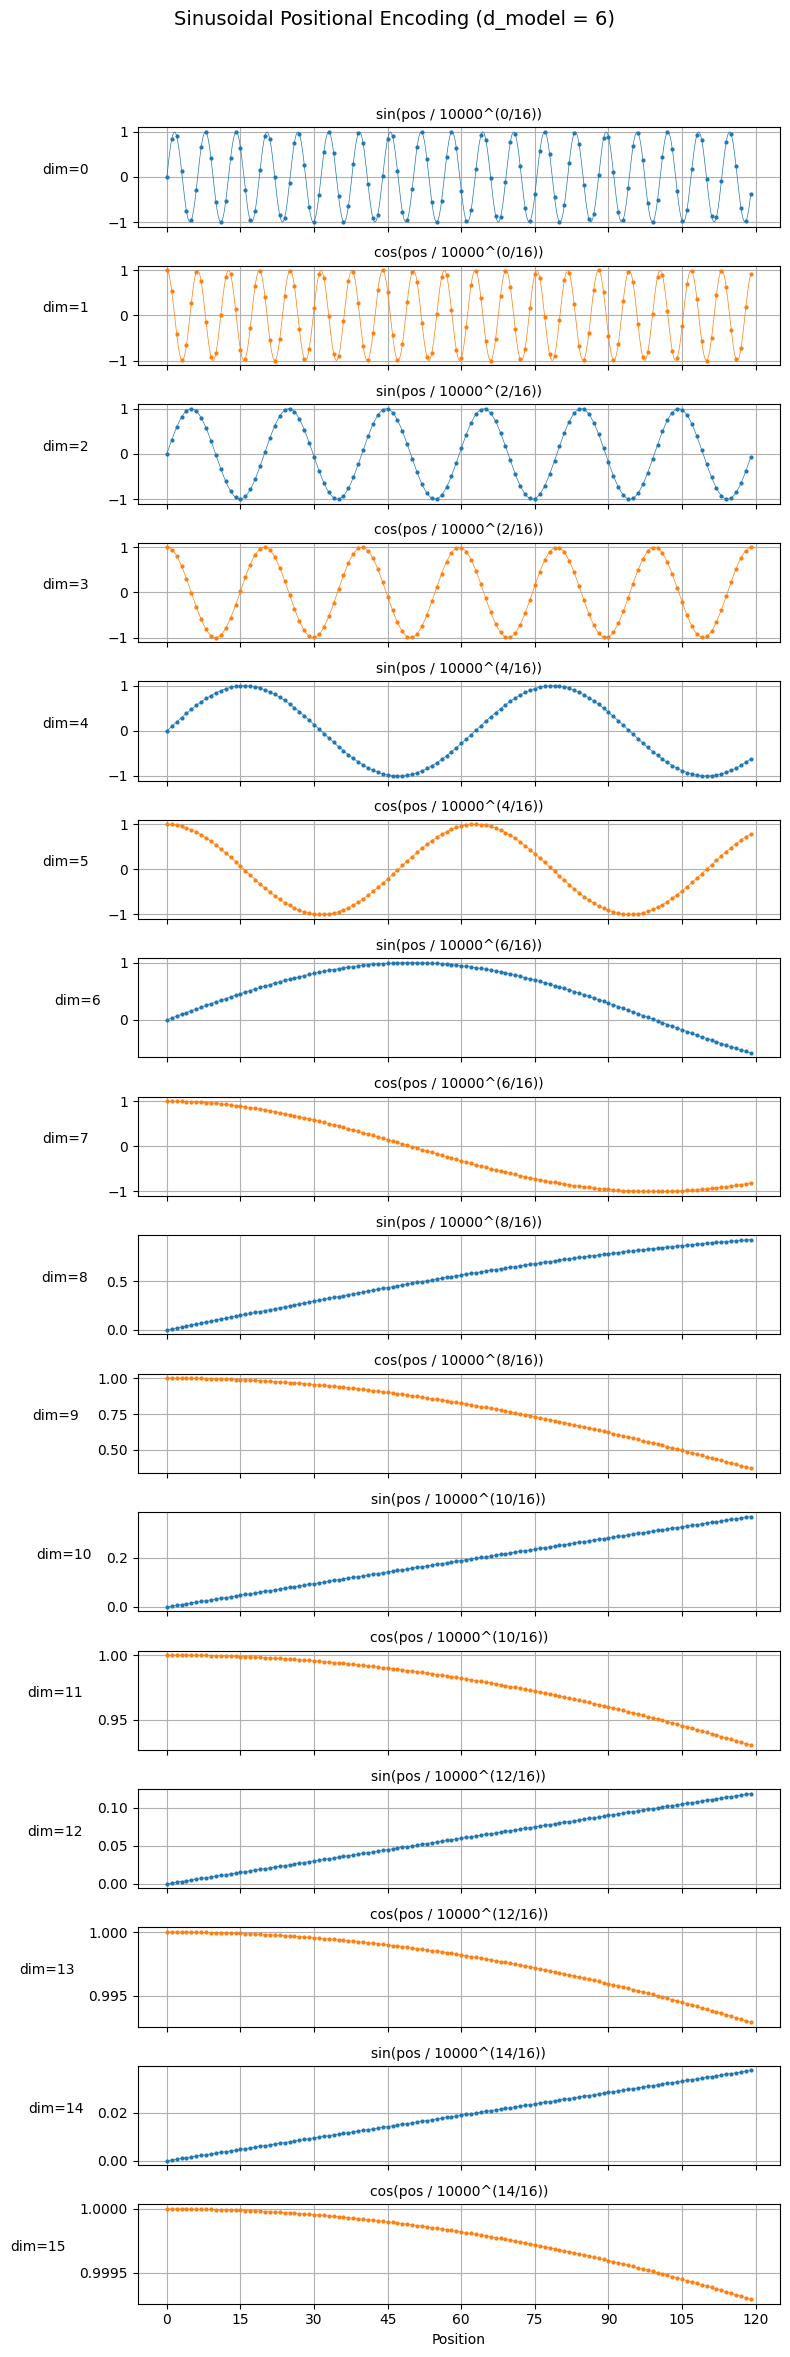

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Parameters
d_model = 16
max_len = 120  # Discrete positions
positions = np.arange(max_len)
real_positions = np.linspace(0, max_len - 1, 500)  # Continuous range

def positional_encoding(pos, i, d_model):
    freq = 10000 ** (2 * (i // 2) / d_model)
    if i % 2 == 0:
        return np.sin(pos / freq)
    else:
        return np.cos(pos / freq)

# Plot setup
fig, axs = plt.subplots(d_model, 1, figsize=(8, 24), sharex=True)

for i in range(d_model):
    freq_power = f"{2*(i//2)}/{d_model}"
    freq = 10000 ** (2 * (i // 2) / d_model)
    discrete_values = [positional_encoding(pos, i, d_model) for pos in positions]
    continuous_values = [positional_encoding(pos, i, d_model) for pos in real_positions]

    # Choose color and label
    if i % 2 == 0:
        color = 'tab:blue'
        func_type = 'sin'
    else:
        color = 'tab:orange'
        func_type = 'cos'

    # Plot continuous curve
    axs[i].plot(real_positions, continuous_values, color=color, lw = .5)

    # Plot discrete points without legend entry
    axs[i].plot(positions, discrete_values, 'o', color=color, label='_nolegend_', ms=2)

    # Subplot title using the formula
    axs[i].set_title(f'{func_type}(pos / 10000^({freq_power}))', fontsize=10)
    axs[i].set_ylabel(f'dim={i}', rotation=0, labelpad=30)
    axs[i].grid(True)
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[-1].set_xlabel('Position')
plt.suptitle('Sinusoidal Positional Encoding (d_model = 6)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()